# Import Graph

In [74]:
import os

# Set the environment variable before importing TensorFlow and TensorFlow GNN
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow as tf
import tensorflow_gnn as tfgnn
import networkx as nx

#  Import networkX graph from file
G = nx.read_graphml('data/graph.graphml')


# Convert Graph to GNN input

In [75]:
# How many edges?
print('Number of edges:', G.number_of_edges())

# How many nodes?
print('Number of nodes:', G.number_of_nodes())

Number of edges: 30
Number of nodes: 32


In [82]:
country_vocab = set()
account_type_vocab = set()
customer_id_vocab = set()

for n, attrs in G.nodes(data=True):
    country_vocab.add(attrs.get("country", "unknown"))
    account_type_vocab.add(attrs.get("type", "unknown"))
    customer_id_vocab.add(attrs.get("customer_id"))

print(f"Country vocab size: {len(country_vocab)}")
print(f"Type vocab size: {len(account_type_vocab)}")
print(f"Customer ID vocab size: {len(customer_id_vocab)}")


# Define a TensorFlow encoder
class NodeAttributeEncoder(tf.keras.layers.Layer):
    def __init__(
        self, country_vocab_size, type_vocab_size, customer_id_vocab_size, output_dim
    ):
        super(NodeAttributeEncoder, self).__init__()
        self.country_embedding = tf.keras.layers.Embedding(
            country_vocab_size, output_dim
        )
        self.account_type_embedding = tf.keras.layers.Embedding(
            type_vocab_size, output_dim
        )
        self.customer_id_normalizer = tf.keras.layers.Embedding(
            customer_id_vocab_size, output_dim
        )

    def call(self, inputs):
        country, customer_id, account_type_ = inputs
        country_encoded = self.country_embedding(country)
        type_encoded = self.account_type_embedding(account_type_)
        customer_id_encoded = self.customer_id_normalizer(customer_id)
        return tf.concat([country_encoded, customer_id_encoded, type_encoded], axis=-1)

class EdgeAttributeEncoder(tf.keras.layers.Layer):
    def __init__(self, type_vocab_size, output_dim):
        super(EdgeAttributeEncoder, self).__init__()
        self.type_embedding = tf.keras.layers.Embedding(type_vocab_size, output_dim)
        self.amount_normalizer = tf.keras.layers.LayerNormalization()
        self.timestamp_normalizer = tf.keras.layers.LayerNormalization()

    def call(self, inputs):
        breakpoint()
        amount, type, timestamp = inputs
        type_encoded = self.type_embedding(type)
        amount_encoded = self.amount_normalizer(amount)
        timestamp_encoded = self.timestamp_normalizer(timestamp)
        return tf.concat([amount_encoded, type_encoded, timestamp_encoded], axis=-1)



node_encoder = NodeAttributeEncoder(
    len(country_vocab), len(account_type_vocab), len(customer_id_vocab), output_dim=1
)

# Encode node attributes to feature vectors
node_features = []
for node, attrs in G.nodes(data=True):
    if "country" in attrs:
        country_idx = list(country_vocab).index(attrs.get("country"))

    type_idx = list(account_type_vocab).index(attrs["type"])

    if "customer_id" in attrs:
        customer_id = list(customer_id_vocab).index(attrs["customer_id"])
    encoded_features = node_encoder(
        (
            tf.convert_to_tensor([country_idx]),
            tf.convert_to_tensor([customer_id]),
            tf.convert_to_tensor([type_idx]),
        )
    )
    node_features.append(encoded_features.numpy().flatten())

node_features_tf = tf.convert_to_tensor(node_features, dtype=tf.float32)


# Encode edge attributes to feature vectors
# edge_type_vocab = set()

# for a,b, attrs in G.edges(data=True):
#     edge_type_vocab.add(attrs.get("type"))

# edge_encoder = EdgeAttributeEncoder(len(edge_type_vocab), output_dim=1)
# edge_features = []
# for a, b, attrs in G.edges(data=True):
#     type_idx = list(edge_type_vocab).index(attrs['type'])
#     amount = attrs.get('amount', 0)
#     timestamp = attrs.get('timestamp', 0)
#     encoded_features = edge_encoder((tf.convert_to_tensor([amount], dtype=tf.float32), 
#                                      tf.convert_to_tensor([type_idx]),
#                                      tf.convert_to_tensor([timestamp], dtype=tf.float32)))
#     edge_features.append(encoded_features.numpy().flatten())

Country vocab size: 2
Type vocab size: 2
Customer ID vocab size: 17


(32, 32)


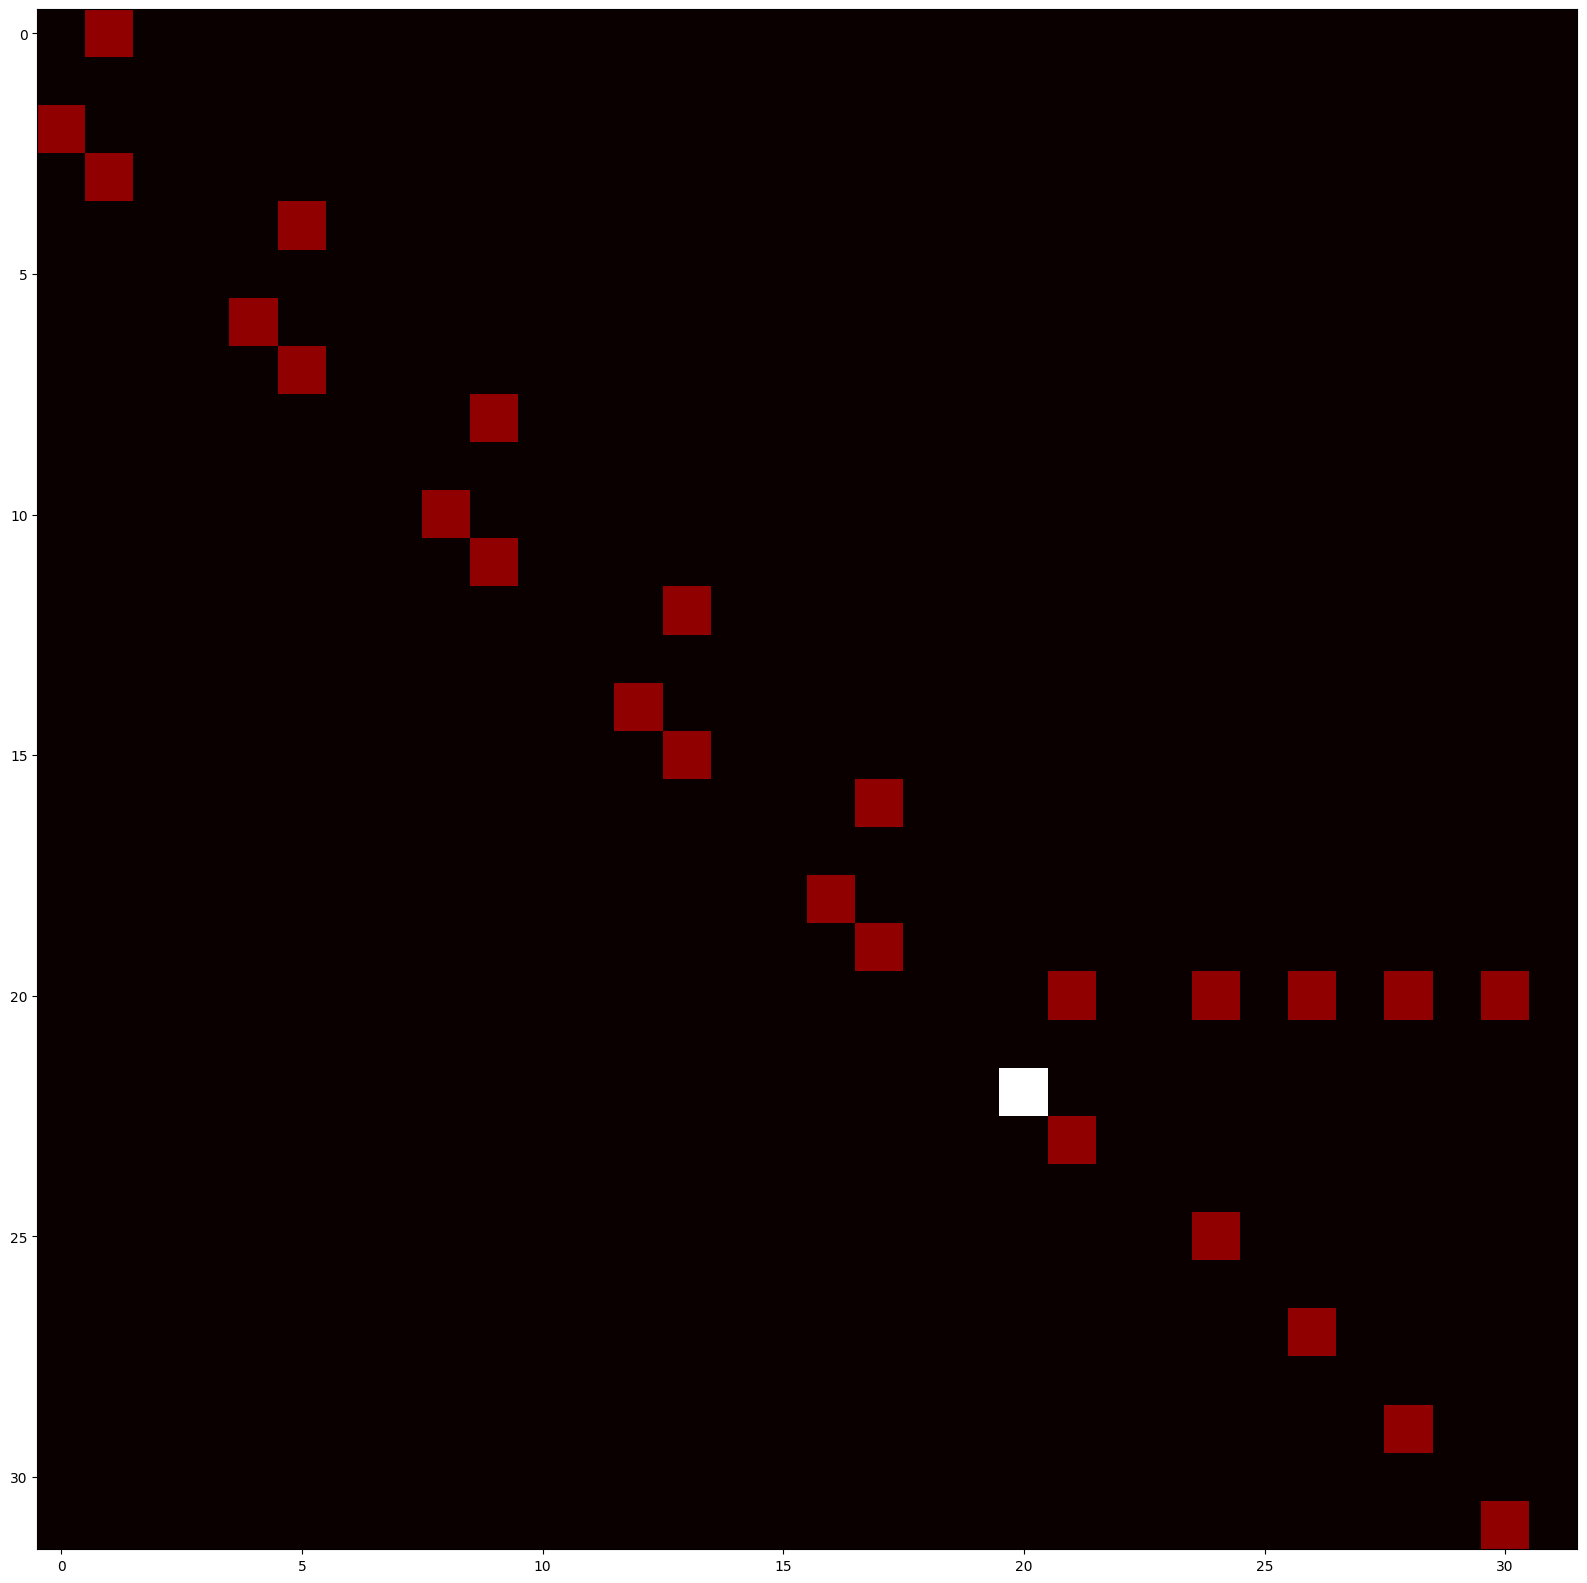

In [81]:
# Convert adjacency matrix to TensorFlow tensor
adj_matrix = nx.adjacency_matrix(G).todense()
# adj_matrix_tf = tf.convert_to_tensor(adj_matrix, dtype=tf.float32)

print(adj_matrix.shape)

# Plot adjancey matrix (282,282) contianing zeros and ones
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.imshow(adj_matrix, cmap='hot')
plt.show()



In [79]:
# import mgclient

# # Connect to Memgraph
# conn = mgclient.connect(host='127.0.0.1', port=7687)
# cursor = conn.cursor()

# # Drop all nodes and edges
# cursor.execute("MATCH (n) DETACH DELETE n")

# # Create nodes and edges in Memgraph
# nodes_size = G.number_of_nodes()
# count = 0
# for id, node_attrs in G.nodes(data=True):
#     if node_attrs['type'] == 'account':
#         tag = 'Account'
#         query_attrs = "{id: $id, country: $country, is_fraud: $is_fraud, customer_id: $customer_id, account_id: $account_id}"
#         query_params = {**node_attrs, 'account_id': id}
#         cursor.execute(f"CREATE (:{tag} {query_attrs})", query_params)
#     else:
#         tag = 'Customer'
#         query_attrs = "{id: $id, is_fraud: $is_fraud}"
#         cursor.execute(f"CREATE (:{tag} {query_attrs})", {'id': id, 'is_fraud': node_attrs['is_fraud']})

#     print(f"Progress: {count}/{nodes_size}")


# # Create edges in Memgraph
# edges_size = G.number_of_edges()
# count = 0
# for a, b, key, edge_attrs in G.edges(data=True, keys=True):
#     # print(a, b, key, edge_attrs)
    
#     if edge_attrs['type'] == 'transfer':
#         # Create edge
#         query_attrs = "{amount: $amount, timestamp: $timestamp, is_fraud: $is_fraud}"
#         cursor.execute(f"""
#             MATCH (a), (b)
#             WHERE a.id = $a AND b.id = $b
#             CREATE (a)-[r:TRANSFER {query_attrs}]->(b)
#             SET r.amount = $amount, r.timestamp = $timestamp, r.is_fraud = $is_fraud
#         """, {'a': a, 'b': b, 'amount': edge_attrs['amount'], 'timestamp': edge_attrs['timestamp'], 'is_fraud': edge_attrs['is_fraud']})
#     else:
#         # Create edge
#         query_attrs = "{type: $type}"
#         cursor.execute(f"""
#             MATCH (a), (b)
#             WHERE a.id = $a AND b.id = $b
#             MERGE (a)-[r:OWNS {query_attrs}]->(b)
#             ON CREATE SET r.type = $type
#         """, {'a': a, 'b': b, 'type': edge_attrs['type']})

#     count += 1
#     print(f"Progress: {count}/{edges_size}")

# # Commit the transaction
# conn.commit()

# # Close the connection
# cursor.close()
# conn.close()

# Create GNN 

In [80]:
# Create a GraphTensor
graph_tensor = tfgnn.GraphTensor.from_pieces(
    node_sets={
        "nodes": tfgnn.NodeSet.from_fields(
            sizes=[len(G.nodes())],
            features={"feature": node_features_tf}
        )
    },
    edge_sets={
        "edges": tfgnn.EdgeSet.from_fields(
            sizes=[len(G.edges())],
            adjacency=tfgnn.Adjacency.from_indices(
                source=("nodes", edge_indices[:, 0]),
                target=("nodes", edge_indices[:, 1])
            )
        )
    }
)

# Print the GraphTensor
print(graph_tensor)

NameError: name 'edge_indices' is not defined